In Bayesian approach we update our believes as we observe new data. 

A colleague of mine asked me if he should update prior recursively (via Bayes theorem) as he gathers more and more data or just better off wait for an experiment to finish and infer posteriors in the very end. Will the final posteriors one would obtain from these two strategies be different?

I suggest both the approach should result the same posteriors assuming you start with same orginial priors.

Let's test this below. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st
import numpy.random as rd
%matplotlib inline

First let's create a synthetic data that is Normally distributed.

In [2]:
n = 2000
mu, std = 100, 25
data = st.norm.rvs(mu, std, n)

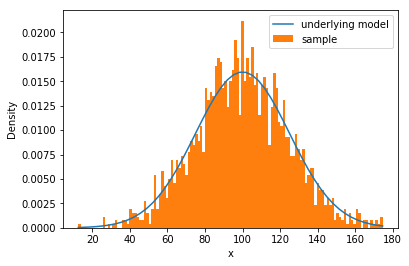

In [3]:
mup = np.linspace(1, 250, 500)

x = np.linspace(data.min(), data.max(), 50)
plt.plot(x,st.norm.pdf(x, loc=mu, scale=std), label='underlying model');
plt.hist(data, bins=125, normed=True, label='sample');
plt.legend()
plt.xlabel('x')
plt.ylabel('Density')

## Prior

Let's assume three different priors to begin with, namely, uniform, gaussian distribution centred at the true mean and another gaussian distribution but with centre shifted (systematically).

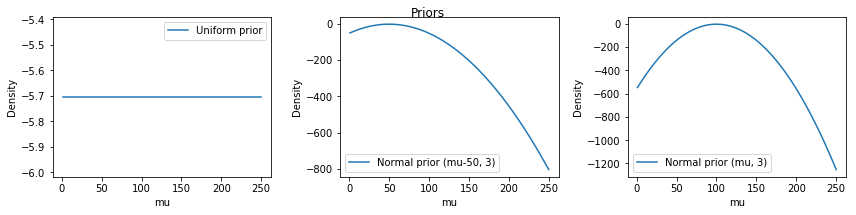

In [4]:
# priors on mu
fig1, ax = plt.subplots(1,3, figsize=(12, 3))

# Uniform prior
p1 = st.uniform.logpdf(mup, 1, 300)
ax[0].plot(mup, p1, label='Uniform prior')

# Normal prior with systematic
p2 = st.norm.logpdf(mup, mu-50, 5)
ax[1].plot(mup, p2, label='Normal prior (mu-50, 3)')

# Normal prior with systematic
p3 = st.norm.logpdf(mup, mu, 3)
ax[2].plot(mup, p3, label='Normal prior (mu, 3)')

for iax in ax:
    iax.set_xlabel('mu')
    iax.set_ylabel('Density')
    iax.legend()

fig1.suptitle('Priors')
fig1.tight_layout()


## Likelihood

To compute the likelihood we need data. Here first let's compute likelihood for a few subsets of the data and see if they agree to some limit (of the scatter)

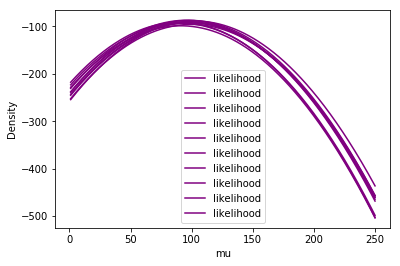

In [5]:
def total_likelihood(mu, std, data):
    yval = []
    for i in mu:
        yval.append(np.sum(st.norm.logpdf(data, loc=i, scale=std)))
    return np.asarray(yval)

# Reshaping the randomly drawn data into small batches 
batch_data = data.reshape(100,20)

# Likelihood
for ix in xrange(10):
    plt.plot(mup, total_likelihood(mup, std, batch_data[ix]), color='purple', label='likelihood')

plt.ylabel('Density')
plt.xlabel('mu')
plt.legend()

We see the likelihoods for different sub-sets of data coincides par scatter.

Next stop in the Bayesian reasoning would be weight the likelihood by prior and construct posterior distribution. 
We do this for all three priors we chose above. 

### Posterior

In [6]:
# Upon provided a list of priors and a likelihood distribution the following function returns posterior 
# corresponding to each prior, and respective figure stamps.

def plot(x, prior, likelihood):
    fig, ax = plt.subplots(1,3, figsize=(10,4))

    posteriors = []
    for iax, pr in zip(ax, prior):
        iax.plot(x, pr, label='prior', lw=2, ls='dashed', marker='.')
        iax.plot(x, likelihood, label='log-likeli', lw=2, color='purple')
    
        posterior = likelihood + pr
        
        posteriors.append(posterior)
        
        iax.plot(x, posterior, label='posterior', lw=2, color='red', ls='--')

        iax.set_xlabel('mu')
        iax.set_ylabel('density')
        iax.set_xlim(0,250)
        iax.legend()
    fig.tight_layout()
    
    return fig, ax, posteriors

### Run 

Finally in the following we do the real calculation of the posterior. At every step for a small batch of 'observed' data we compute likelihood and posterior. For the next iteration resulted posterior will be fed as a prior and multiplied with the new likelihood obtained with new batch of 'observed' data. We run this for a few iteration. 

Iteration : 0
Iteration : 1
Iteration : 2
Iteration : 3
Iteration : 4
Iteration : 5
Iteration : 6
Iteration : 7
Iteration : 8
Iteration : 9
Iteration : 10
Iteration : 11
Iteration : 12
Iteration : 13
Iteration : 14


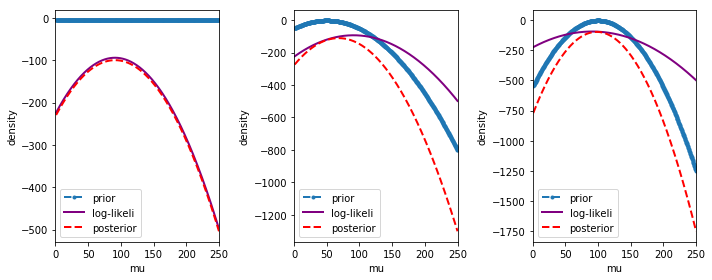

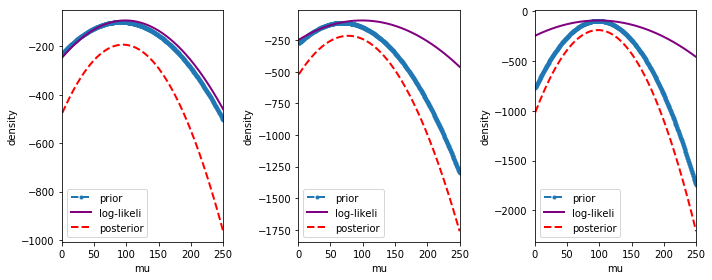

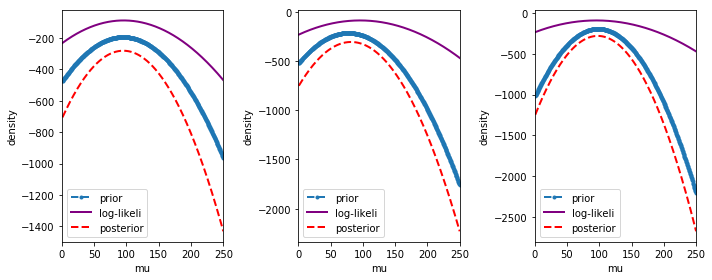

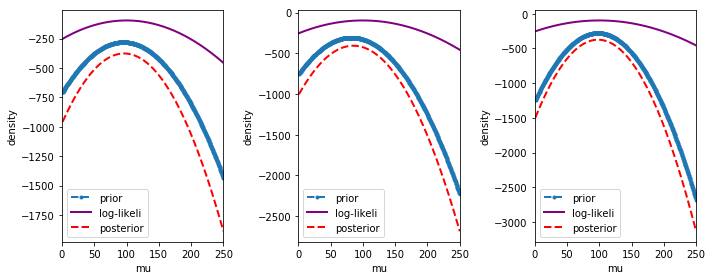

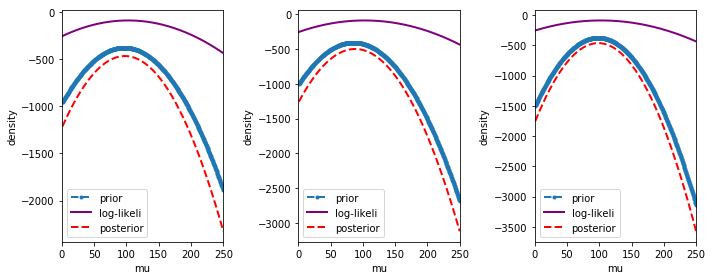

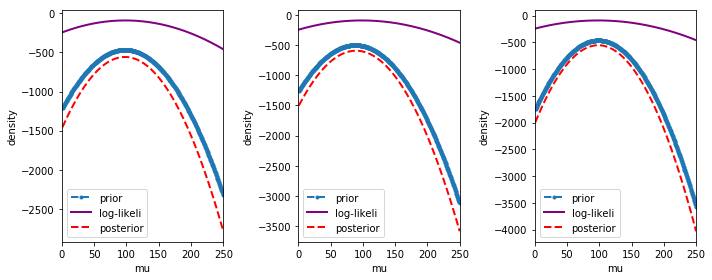

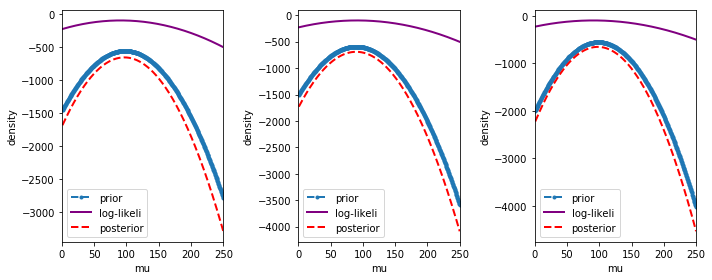

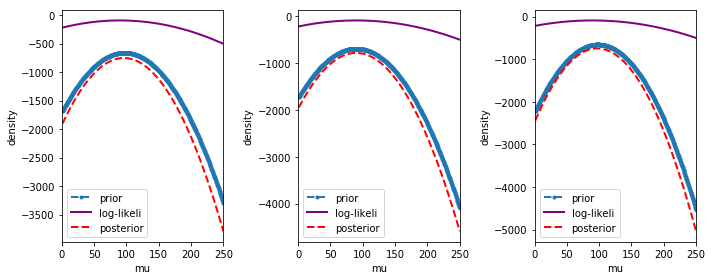

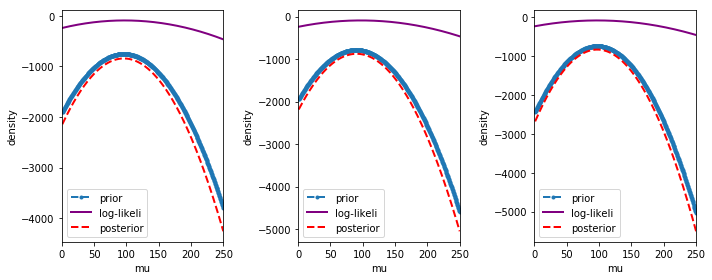

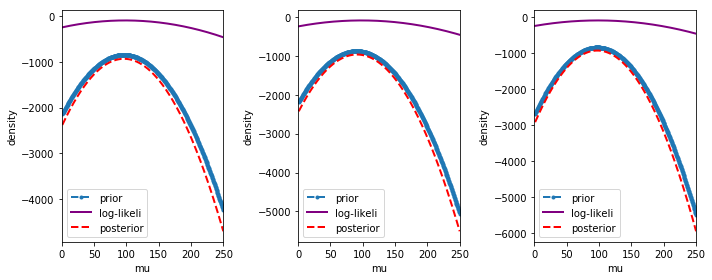

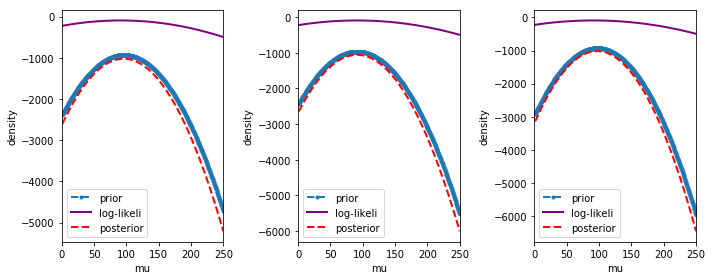

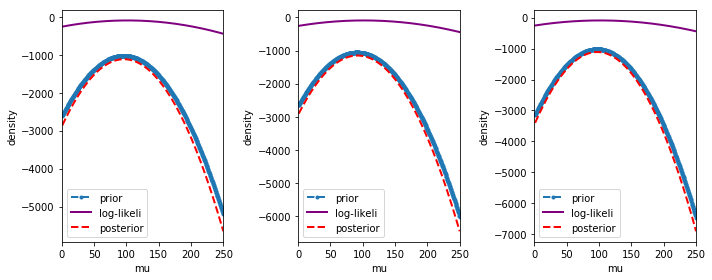

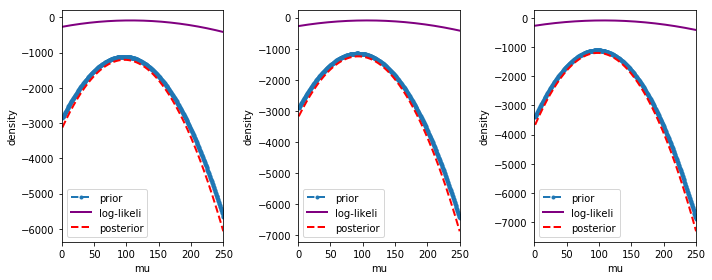

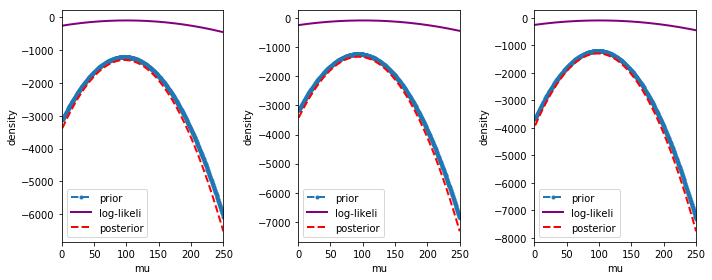

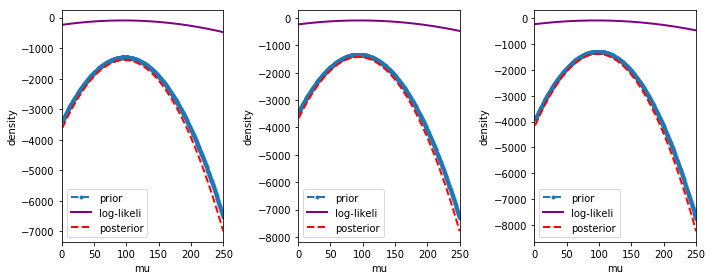

In [7]:
prior = np.asarray([p1, p2, p3])
for j in xrange(15):
    lnhood = total_likelihood(mup, std, batch_data[j])

    print 'Iteration : %d'%j
    fig, ax, posterior = plot(mup, prior, lnhood)
    prior = posterior

We see that as we progress downwards posteriors show better agreement with log-likelihood. 

### Likelihood calculation on entire data, single update

Now, it is time to infer the posteriors collectively from all the data used above in one go. 

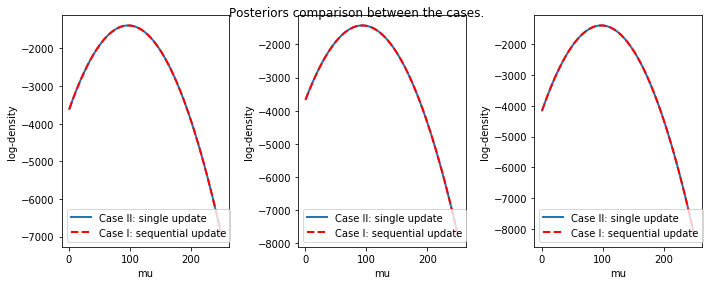

In [17]:
# These are the same priors we started in the beginning of the above case
prior = np.asarray([p1, p2, p3])

# Likelihood for the full data
lnhood_full = total_likelihood(mup, std, batch_data[:15].reshape(300))

# Posteriors and corresponding plots

fig, ax = plt.subplots(1,3, figsize=(10,4))

ax[0].plot(mup, lnhood_full + prior[0], label = 'Case II: single update', lw=2)
ax[0].plot(mup, posterior[0], 'r--', label = 'Case I: sequential update', lw=2)

ax[1].plot(mup, lnhood_full + prior[1], label = 'Case II: single update', lw=2)
ax[1].plot(mup, posterior[1], 'r--', label = 'Case I: sequential update', lw=2)

ax[2].plot(mup, lnhood_full + prior[2], label = 'Case II: single update', lw=2)
ax[2].plot(mup, posterior[2], 'r--', label = 'Case I: sequential update', lw=2)

for iax in ax:
    iax.legend()
    iax.set_xlabel('mu')
    iax.set_ylabel('log-density')
    
fig.suptitle('Posteriors comparison between the cases.')
fig.tight_layout()

That is now a happy-ending. We see the posteriors for both the cases agree to each other quite neatly for all three choices of priors.

One note however, in case one is dealing with large number of data points the Case I (case of sequential update) will be memory lighter than Case II (case of single update). 

Reference:

    https://alexanderetz.com/2015/07/25/understanding-bayes-updating-priors-via-the-likelihood/